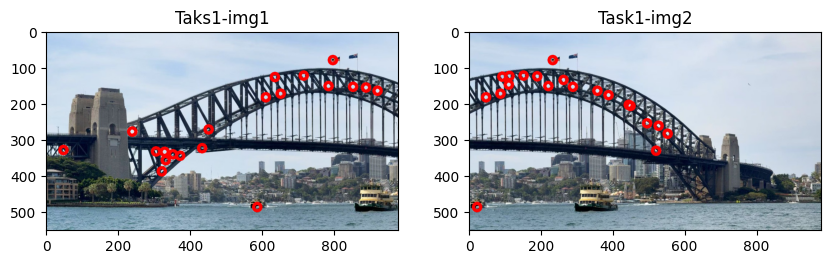

In b), I used [sift = cv2.SIFT_create(nfeatures=50, contrastThreshold=0.02)], select a large number of most distinctive points and gather their coordinates to select 20 key points with different coordinates. To increase the visibility of feature points, I used [cv2. circle (img, (x, y), 10, (255, 0, 0), 7)], changing the color of the key points to red, setting redis to 10, and thickness to 7



In [93]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import random_noise

img1 = cv2.imread('./IMG-1.jpg')
img2 = cv2.imread('./IMG-2.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

def pltShow(img1, label1, img2, label2):
    plt.figure(figsize=(10, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title(label1)
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title(label2)
    plt.show()

import cv2
import numpy as np

def DrawKeyPoint(img): 
    photo = img.copy()
    sift = cv2.SIFT_create(nfeatures=50, contrastThreshold=0.02) 
    kps = sift.detect(photo, None)
    used_points = set()
    max_keypoints = 20
    count = 0 
    for kp in kps:
        x, y = round(kp.pt[0]), round(kp.pt[1])
        if (x, y) in used_points:
            continue
        cv2.circle(photo, (x, y), radius=10, color=(255, 0, 0), thickness=7)
        used_points.add((x, y))
        count += 1
        if count >= max_keypoints:
            break
    return photo

pltShow(DrawKeyPoint(img1), "Taks1-img1", DrawKeyPoint(img2), "Task1-img2")
print("In b), I used [sift = cv2.SIFT_create(nfeatures=50, contrastThreshold=0.02)], select a large number of most distinctive points and gather their coordinates to select 20 key points with different coordinates. To increase the visibility of feature points, I used [cv2. circle (img, (x, y), 10, (255, 0, 0), 7)], changing the color of the key points to red, setting redis to 10, and thickness to 7\n")

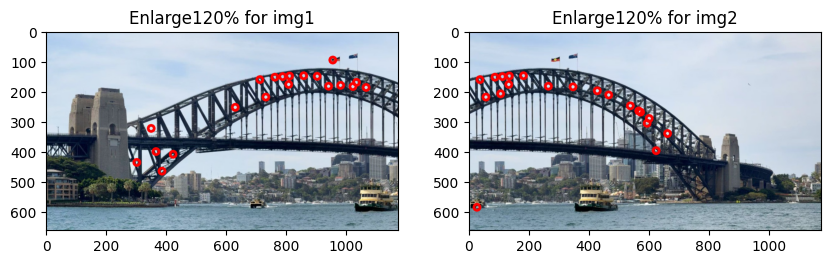

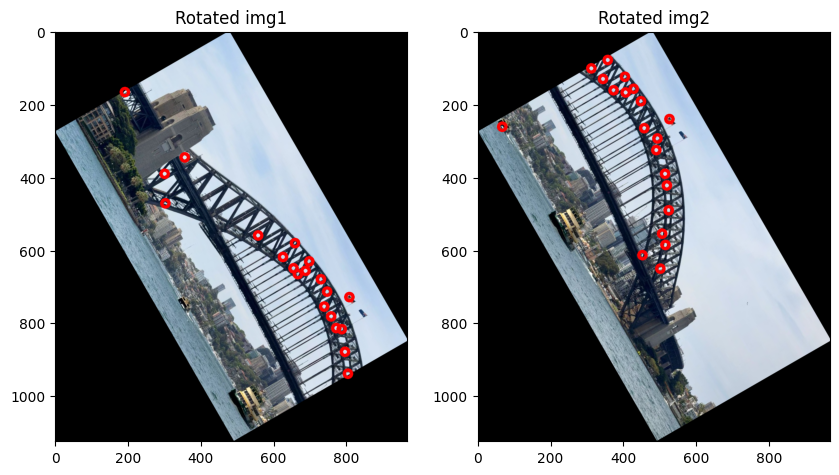

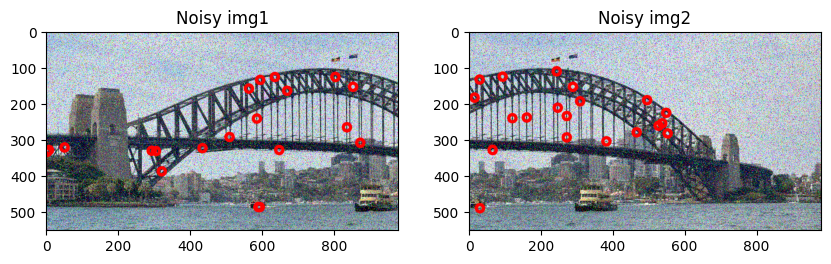

(1) The key points of the processed image are roughly the same as those of the original image,but there are differences in the similarity among the three situations.
(2) SIFT is highly robust to scaling, it should perform well as it detects keypoints in a scale-invariant manner. In addition, SIFT remains effective since it is also rotation-invariant. However, SIFT’s performance may degrade because noise can alter keypoint detection and descriptor computation.
(3) Among the three, scaling is the most reliable for SIFT, because its multi-scale feature detection ensures stable keypoint matching.


In [94]:
def Resize120(img):
    img_rec = cv2.resize(img, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_AREA)
    img_rec_kp = DrawKeyPoint(img_rec)
    return img_rec_kp

pltShow(Resize120(img1), "Enlarge120% for img1", Resize120(img2), "Enlarge120% for img2")

def Rotate60(img):
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    R_matrix = cv2.getRotationMatrix2D(center, -60, 1.0)
    cos = np.abs(R_matrix[0, 0])
    sin = np.abs(R_matrix[0, 1])
    new_w = int(h * sin + w * cos)
    new_h = int(h * cos + w * sin)
    R_matrix[0, 2] += (new_w - w) / 2
    R_matrix[1, 2] += (new_h - h) / 2
    rotated = cv2.warpAffine(img, R_matrix, (new_w, new_h))
    rotated_kp = DrawKeyPoint(rotated)
    return rotated_kp

pltShow(Rotate60(img1), 'Rotated img1', Rotate60(img2), 'Rotated img2')

def noiseAdd(img):
    noisy_img = random_noise(img, mode='s&p', amount=0.2)    
    noisy_img = (noisy_img * 255).astype(np.uint8)
    noisy_img_kp = DrawKeyPoint(noisy_img)
    return noisy_img_kp

pltShow(noiseAdd(img1), "Noisy img1", noiseAdd(img2), "Noisy img2")
print('(1) The key points of the processed image are roughly the same as those of the original image,but there are differences in the similarity among the three situations.')
print('(2) SIFT is highly robust to scaling, it should perform well as it detects keypoints in a scale-invariant manner. In addition, SIFT remains effective since it is also rotation-invariant. However, SIFT’s performance may degrade because noise can alter keypoint detection and descriptor computation.')
print('(3) Among the three, scaling is the most reliable for SIFT, because its multi-scale feature detection ensures stable keypoint matching.')


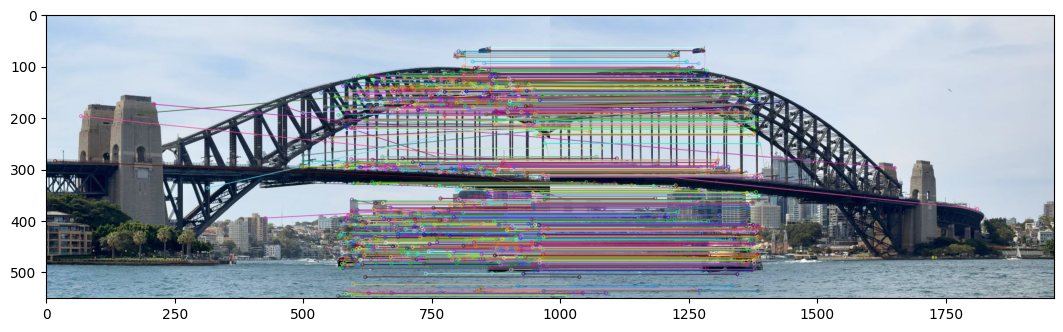

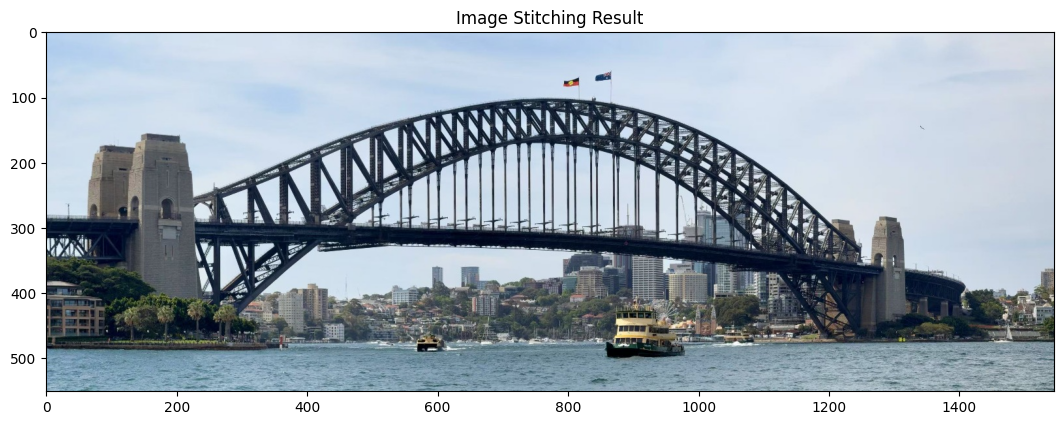

In [95]:
img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

def sift_kp_des(img):
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

# get KeyPoints and description of kpts
kp1, des1 = sift_kp_des(img1_gray)
kp2, des2 = sift_kp_des(img2_gray)
bf = cv2.BFMatcher()    # Keypoint Matching
matches = bf.knnMatch(des1, des2, k=2)
goodPoint = []    # filtering good points
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        goodPoint.append([m])
img_match = cv2.drawMatchesKnn(img1, kp1, img2, kp2, goodPoint, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(13, 13))
plt.imshow(img_match)
plt.show()

# get information of original points and aim points
origin_pts = []
aim_pts = []
for m in goodPoint:
    m = m[0]
    origin_index = m.queryIdx
    aim_index = m.trainIdx
    origin_pts.append(kp1[origin_index].pt)
    aim_pts.append(kp2[aim_index].pt)
origin_pts = np.float32(origin_pts).reshape(-1, 1, 2)
aim_pts = np.float32(aim_pts).reshape(-1, 1, 2)

# calculate new height and width
M, mask = cv2.findHomography(origin_pts, aim_pts, cv2.RANSAC, 5.0)
h1, w1 = img1_gray.shape[:2]
h2, w2 = img2_gray.shape[:2]
pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
pts1_transformed = cv2.perspectiveTransform(pts1, M)

# Matching the new height and width
pts2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
all_pts = np.concatenate((pts1_transformed, pts2), axis=0)

[x_min, y_min] = np.int32(all_pts.min(axis=0).flatten() - 0.5)
[x_max, y_max] = np.int32(all_pts.max(axis=0).flatten() + 0.5)
new_w = x_max - x_min
new_h = y_max - y_min

M_translation = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])  
M_updated = M_translation @ M 
result = cv2.warpPerspective(img1, M_updated, (new_w, new_h))
result[-y_min:h2 - y_min, -x_min:w2 - x_min] = img2  

plt.figure(figsize=(13, 13))
plt.imshow(result)
plt.title("Image Stitching Result")
plt.show()